<a href="https://colab.research.google.com/github/WadieAC/riesgos/blob/main/CVAE_MTM_wadie_albakri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

modelar una distribución compleja (como una distribución de diferencias con contrapartida, probablemente relacionada con P&L o XVA) en función del movimiento del mercado, lo cual abre la puerta a técnicas generativas condicionadas.

Te planteo varias opciones según los modelos que has mencionado (VAE, GMM, GAN), con enfoque condicionado al mercado


1. Conditional Variational Autoencoder (CVAE)
Objetivo: Aprender la distribución de diferencias condicional a un vector de mercado.

Arquitectura:

Input: x = [features de mercado], y = [diferencias observadas]
- Encoder: q(z | y, x) → codifica y condicionado en x
- Decoder: p(y | z, x) → genera y condicionado en x y latente z
Ventajas:

Estable, interpretable.
Puedes muestrear nuevas distribuciones condicionadas al mercado actual.
Uso:

Para cada nuevo estado de mercado x, puedes muestrear z ~ N(0, I) y generar posibles y.


2. Conditional GAN (CGAN)
Objetivo: Aprender a generar muestras de tu distribución objetivo condicionada al mercado.

Arquitectura:

- Generador: G(z, x) → genera diferencias condicionadas al vector de mercado.
- Discriminador: D(y, x) → distingue entre diferencias reales y generadas, también condicionado en el mercado.

Ventajas:

Mejor para capturar distribuciones multimodales o con colas pesadas.
Uso:

Para cada mercado x, genera múltiples muestras G(z, x) para obtener tu distribución estimada.


3. Gaussian Mixture Model condicionado (como MoE o GMM paramétrico)
Objetivo: Estimar la distribución como mezcla gaussiana cuyos parámetros dependen del mercado.

Estrategias:

Usar una red que, dada x, devuelva los parámetros de un GMM (μ_k(x), Σ_k(x), π_k(x)).
Esto puede implementarse como un Mixture Density Network.
Ventajas:

Más interpretable y con un enfoque probabilístico explícito.
Más simple de entrenar que GANs.


Recomendación según tus objetivos:
Objetivo	                    Modelo Ideal
Precisión en colas/extremos: CGAN
Probabilístico y estable: CVAE
Interpretabilidad y velocidad	: GMM condicional


ARQUITECTURA RESUMIDA
--------------------------------

Encoder(y, x_market, label) → z ~ q(z | y, x_market, label)
Decoder(z, x_market, label) → y_hat ~ p(y | z, x_market, label)
L = ReconstructionLoss(y, y_hat) + β * KL[q(z|...) || N(0, I)]




In [1]:
#1. Arquitectura del CVAE en TensorFlow

import tensorflow as tf
from tensorflow.keras import layers, models, losses

# Configuración de dimensiones
input_market_dim = 50  # cambia según tus features de mercado
label_dim = 10         # one-hot o embedding
latent_dim = 8

# Encoder
def build_encoder():
    y_input = layers.Input(shape=(1,), name='y_input')
    x_input = layers.Input(shape=(input_market_dim,), name='x_market_input')
    label_input = layers.Input(shape=(label_dim,), name='label_input')

    x = layers.Concatenate()([y_input, x_input, label_input])
    h = layers.Dense(64, activation='relu')(x)
    h = layers.Dense(32, activation='relu')(h)

    z_mean = layers.Dense(latent_dim, name='z_mean')(h)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(h)

    return models.Model(inputs=[y_input, x_input, label_input], outputs=[z_mean, z_log_var], name='encoder')

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Decoder
def build_decoder():
    z_input = layers.Input(shape=(latent_dim,), name='z_input')
    x_input = layers.Input(shape=(input_market_dim,), name='x_market_input')
    label_input = layers.Input(shape=(label_dim,), name='label_input')

    x = layers.Concatenate()([z_input, x_input, label_input])
    h = layers.Dense(32, activation='relu')(x)
    h = layers.Dense(64, activation='relu')(h)
    y_output = layers.Dense(1, name='y_output')(h)

    return models.Model(inputs=[z_input, x_input, label_input], outputs=y_output, name='decoder')

# CVAE model
class CVAE(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super(CVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()

    def compile(self, optimizer):
        super(CVAE, self).compile()
        self.optimizer = optimizer
        self.loss_fn = losses.MeanSquaredError()

    def train_step(self, data):
        y, x_market, label = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder([y, x_market, label])
            z = self.sampling([z_mean, z_log_var])
            y_pred = self.decoder([z, x_market, label])

            recon_loss = self.loss_fn(y, y_pred)
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "recon_loss": recon_loss, "kl_loss": kl_loss}


In [ ]:
# Crear y compilar modelo
encoder = build_encoder()
decoder = build_decoder()
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer=tf.keras.optimizers.Adam())

# Entrenar
# dataset = tf.data.Dataset.from_tensor_slices((y_train, x_market_train, label_train)).batch(64)
# cvae.fit(dataset, epochs=30)


In [2]:
## PREPROCESAMIENTO EN KERAS

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Simulación de datos
n_samples = 1000
n_market_features = 50
n_labels = 10

# Datos simulados
df = pd.DataFrame({
    'mtm_reldiff_usd': np.random.randn(n_samples),
    'monet_code': np.random.choice([f'model_{i}' for i in range(n_labels)], size=n_samples)
})

market_data = np.random.randn(n_samples, n_market_features)
market_df = pd.DataFrame(market_data, columns=[f'market_feat_{i}' for i in range(n_market_features)])
df = pd.concat([df, market_df], axis=1)

# One-hot encoding de etiquetas
label_list = sorted(df['monet_code'].unique())
label_index = {k: v for v, k in enumerate(label_list)}
df['label_idx'] = df['monet_code'].map(label_index)
labels = to_categorical(df['label_idx'], num_classes=n_labels)

# Tensores
y_tensor = df['mtm_reldiff_usd'].values.reshape(-1, 1).astype(np.float32)
x_market_tensor = df[[f'market_feat_{i}' for i in range(n_market_features)]].values.astype(np.float32)
label_tensor = labels.astype(np.float32)

# Dataset en Keras
dataset = tf.data.Dataset.from_tensor_slices(((y_tensor, x_market_tensor, label_tensor), y_tensor))
dataset = dataset.shuffle(buffer_size=1024).batch(64)


In [3]:
## ARQITECTURA CVAE EN KERAS

from tensorflow.keras import layers, models

latent_dim = 8

# Encoder
def build_encoder():
    y_input = layers.Input(shape=(1,))
    x_input = layers.Input(shape=(n_market_features,))
    label_input = layers.Input(shape=(n_labels,))
    x = layers.Concatenate()([y_input, x_input, label_input])
    h = layers.Dense(64, activation='relu')(x)
    h = layers.Dense(32, activation='relu')(h)
    z_mean = layers.Dense(latent_dim)(h)
    z_log_var = layers.Dense(latent_dim)(h)
    return models.Model([y_input, x_input, label_input], [z_mean, z_log_var])

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Decoder
def build_decoder():
    z_input = layers.Input(shape=(latent_dim,))
    x_input = layers.Input(shape=(n_market_features,))
    label_input = layers.Input(shape=(n_labels,))
    x = layers.Concatenate()([z_input, x_input, label_input])
    h = layers.Dense(32, activation='relu')(x)
    h = layers.Dense(64, activation='relu')(h)
    y_output = layers.Dense(1)(h)
    return models.Model([z_input, x_input, label_input], y_output)


In [4]:
## Modelo completo y entrenamiento

class CVAE(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super(CVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.mse_loss_fn = tf.keras.losses.MeanSquaredError()

    def train_step(self, data):
        (y, x_market, label), y_true = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder([y, x_market, label])
            z = self.sampling([z_mean, z_log_var])
            y_pred = self.decoder([z, x_market, label])
            recon_loss = self.mse_loss_fn(y_true, y_pred)
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": total_loss, "reconstruction_loss": recon_loss, "kl_loss": kl_loss}

# Instancia y entrenamiento
encoder = build_encoder()
decoder = build_decoder()
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer=tf.keras.optimizers.Adam())

# Entrenar
cvae.fit(dataset, epochs=30)


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 0.2099 - loss: 1.5361 - reconstruction_loss: 1.3262
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - kl_loss: 0.0979 - loss: 1.2091 - reconstruction_loss: 1.1112
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - kl_loss: 0.0544 - loss: 1.0672 - reconstruction_loss: 1.0128
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - kl_loss: 0.0359 - loss: 1.0071 - reconstruction_loss: 0.9712
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - kl_loss: 0.0266 - loss: 0.9652 - reconstruction_loss: 0.9386
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - kl_loss: 0.0200 - loss: 0.9095 - reconstruction_loss: 0.8895
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - kl_loss: 0.0164 - loss: 0.9221 - reconstruction_loss: 0.9057
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - kl_loss: 0.0140 - loss: 0.8829 - reconstruction_loss: 0.8689
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 0.0125 - loss: 0.8578 - reconstr

In [5]:
## Generación de muestras con el CVAE entrenado

def sample_mtm_reldiff(cvae, x_market, monet_code_str, label_index, n_samples=100):
    # Codificar monet_code a one-hot
    label_idx = label_index[monet_code_str]
    label_one_hot = tf.one_hot([label_idx], depth=len(label_index))
    label_tile = tf.tile(label_one_hot, [n_samples, 1])

    # Repetir estado de mercado
    x_market = tf.convert_to_tensor(x_market, dtype=tf.float32)
    if len(x_market.shape) == 1:
        x_market = tf.expand_dims(x_market, 0)
    x_market_tile = tf.tile(x_market, [n_samples, 1])

    # Muestreo desde z ~ N(0, I)
    z = tf.random.normal(shape=(n_samples, latent_dim))

    # Generar muestras
    y_generated = cvae.decoder([z, x_market_tile, label_tile])
    return y_generated.numpy().flatten()


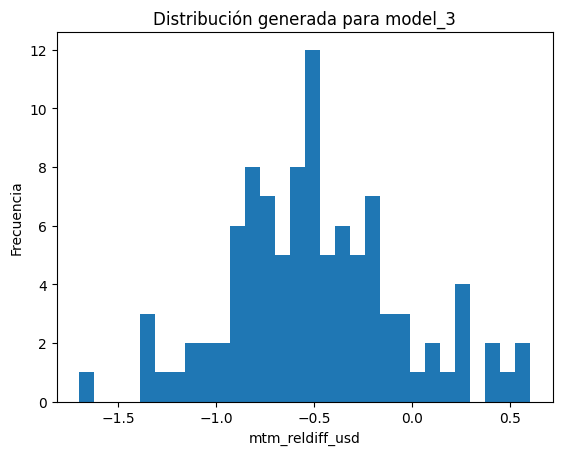

In [6]:
## Ejemplo de USO

'''
Esto te permite realizar stress testing sintético,
análisis de colas o generar escenarios adversos,
condicionados tanto al mercado como al modelo de valoración.

'''

# Simulamos un mercado y un código de modelo
x_new_market = np.random.randn(n_market_features)
monet_code_sample = 'model_3'

# Generar 100 muestras
generated_samples = sample_mtm_reldiff(
    cvae=cvae,
    x_market=x_new_market,
    monet_code_str=monet_code_sample,
    label_index=label_index,
    n_samples=100
)

# Visualización (por ejemplo)
import matplotlib.pyplot as plt
plt.hist(generated_samples, bins=30)
plt.title(f'Distribución generada para {monet_code_sample}')
plt.xlabel('mtm_reldiff_usd')
plt.ylabel('Frecuencia')
plt.show()



In [9]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.6 MB/s eta 0:00:00


In [10]:
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Simular una función generadora (sustituye con CVAE real)
def generate_distribution(market_snapshot, monet_code, n_samples):
    np.random.seed(42)
    base = 0.2 if monet_code == 'model_3' else 0.0
    samples = np.random.normal(loc=base, scale=1.0, size=n_samples)
    return samples

# Función para interfaz

def compare_distributions(market_feat_0, monet_code, n_samples):
    # Real sample dummy (como si fuese histórico de model_3)
    real_data = np.random.normal(loc=0, scale=1, size=500)

    # Generado
    generated_data = generate_distribution(market_feat_0, monet_code, n_samples)

    # KDE
    kde_real = gaussian_kde(real_data)
    kde_gen = gaussian_kde(generated_data)
    x_vals = np.linspace(min(real_data.min(), generated_data.min()) - 1,
                         max(real_data.max(), generated_data.max()) + 1, 500)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, kde_real(x_vals), label='Real', linewidth=2)
    plt.plot(x_vals, kde_gen(x_vals), label='Generado', linestyle='--', linewidth=2)
    plt.title(f"Distribuci\u00f3n para {monet_code}")
    plt.xlabel("mtm_reldiff_usd")
    plt.ylabel("Densidad estimada")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Guardar imagen en buffer
    import io
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    return buf

# Gradio UI
interface = gr.Interface(
    fn=compare_distributions,
    inputs=[
        gr.Slider(-3.0, 3.0, value=0.0, label="market_feat_0 (snapshot simulado)"),
        gr.Dropdown([f"model_{i}" for i in range(10)], label="monet_code"),
        gr.Slider(50, 1000, step=50, value=200, label="N muestras generadas")
    ],
    outputs=gr.Image(type="pil"),
    title="CVAE - Generación Condicionada",
    description="Compara la distribución generada con la real para un estado de mercado y código de modelo"
)

# Ejecutar interfaz
interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9cd76233c8df93030c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


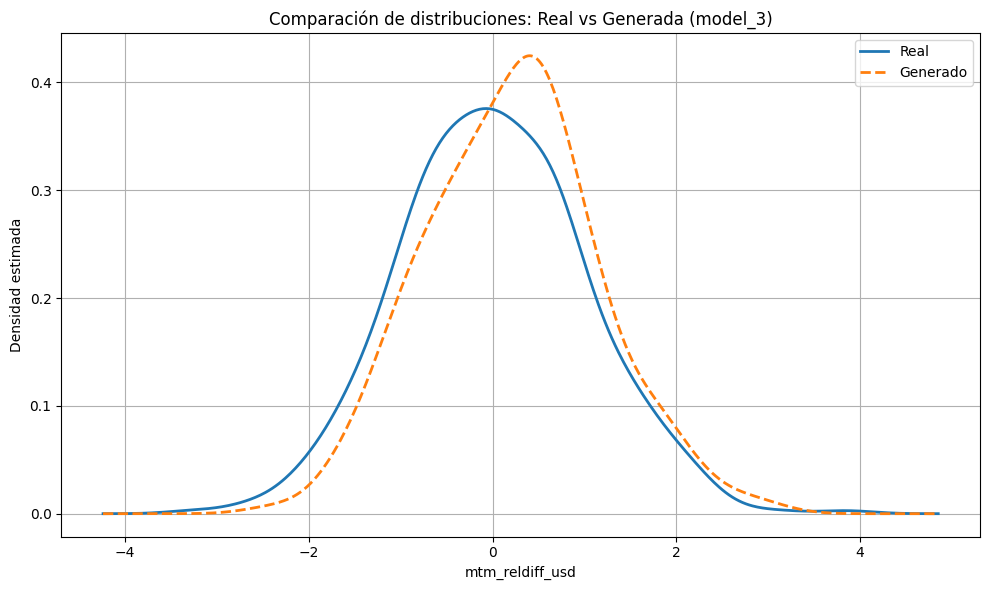

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Simulación de generación con un modelo (sustituir con tu CVAE si quieres)
def generate_distribution(market_snapshot, monet_code, n_samples=100):
    """
    Simula la salida de un modelo generativo como un CVAE.
    """
    np.random.seed(42)  # reproducibilidad
    base = 0.2 if monet_code == 'model_3' else 0.0
    samples = np.random.normal(loc=base + 0.1 * market_snapshot, scale=1.0, size=n_samples)
    return samples

# Simulación de datos reales históricos para model_3
real_data = np.random.normal(loc=0.0, scale=1.0, size=500)

# Generación para un nuevo estado de mercado
market_feat_0 = 0.5  # valor simulado del mercado
monet_code = 'model_3'  # código del modelo a simular
generated_data = generate_distribution(market_feat_0, monet_code, n_samples=200)

# Estimación de densidad KDE
kde_real = gaussian_kde(real_data)
kde_gen = gaussian_kde(generated_data)
x_vals = np.linspace(min(real_data.min(), generated_data.min()) - 1,
                     max(real_data.max(), generated_data.max()) + 1, 500)

# Gráfico comparativo
plt.figure(figsize=(10, 6))
plt.plot(x_vals, kde_real(x_vals), label="Real", linewidth=2)
plt.plot(x_vals, kde_gen(x_vals), label="Generado", linestyle="--", linewidth=2)
plt.title(f"Comparación de distribuciones: Real vs Generada ({monet_code})")
plt.xlabel("mtm_reldiff_usd")
plt.ylabel("Densidad estimada")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



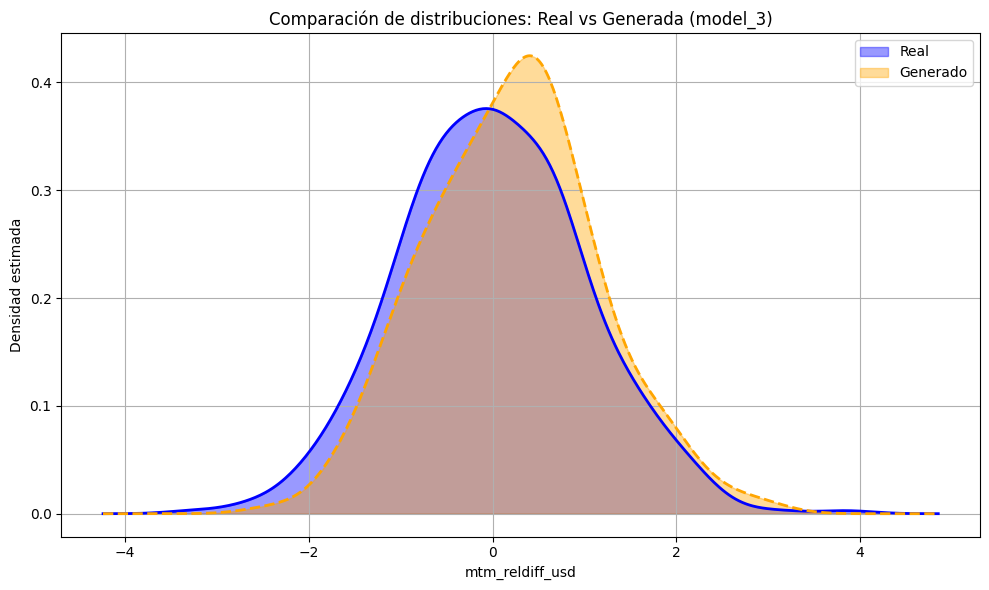

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Simulación de distribución generada
def generate_distribution(market_snapshot, monet_code, n_samples=100):
    np.random.seed(42)
    base = 0.2 if monet_code == 'model_3' else 0.0
    samples = np.random.normal(loc=base + 0.1 * market_snapshot, scale=1.0, size=n_samples)
    return samples

# Datos reales simulados (por ejemplo históricos)
real_data = np.random.normal(loc=0.0, scale=1.0, size=500)

# Datos generados para un snapshot de mercado y código
market_feat_0 = 0.5
monet_code = 'model_3'
generated_data = generate_distribution(market_feat_0, monet_code, n_samples=200)

# KDE estimators
kde_real = gaussian_kde(real_data)
kde_gen = gaussian_kde(generated_data)
x_vals = np.linspace(min(real_data.min(), generated_data.min()) - 1,
                     max(real_data.max(), generated_data.max()) + 1, 500)
y_real = kde_real(x_vals)
y_gen = kde_gen(x_vals)

# Graficar densidades con relleno
plt.figure(figsize=(10, 6))
plt.fill_between(x_vals, y_real, alpha=0.4, label='Real', color='blue')
plt.fill_between(x_vals, y_gen, alpha=0.4, label='Generado', color='orange')
plt.plot(x_vals, y_real, color='blue', linewidth=2)
plt.plot(x_vals, y_gen, color='orange', linewidth=2, linestyle='--')

plt.title(f"Comparación de distribuciones: Real vs Generada ({monet_code})")
plt.xlabel("mtm_reldiff_usd")
plt.ylabel("Densidad estimada")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import gaussian_kde, wasserstein_distance
from scipy.integrate import simps
from scipy.special import rel_entr
import numpy as np

# Simulación de datos
np.random.seed(42)
real_data = np.random.normal(loc=0.0, scale=1.0, size=500)
generated_data = np.random.normal(loc=0.2, scale=1.0, size=200)

# KDE estimators
kde_real = gaussian_kde(real_data)
kde_gen = gaussian_kde(generated_data)

# Rango de evaluación
x_vals = np.linspace(min(real_data.min(), generated_data.min()) - 1,
                     max(real_data.max(), generated_data.max()) + 1, 1000)
y_real = kde_real(x_vals)
y_gen = kde_gen(x_vals)

# Normalizar
y_real /= simps(y_real, x_vals)
y_gen /= simps(y_gen, x_vals)

# Área de solapamiento
overlap_area = simps(np.minimum(y_real, y_gen), x_vals)

# Distancia de Wasserstein
wass_dist = wasserstein_distance(real_data, generated_data)

# KL Divergence (KL(real || gen))
kl_div = simps(rel_entr(y_real, y_gen), x_vals)

# Entropía cruzada
cross_entropy = -simps(y_real * np.log(y_gen + 1e-12), x_vals)

# Log-likelihood promedio de los generados bajo la real
avg_log_likelihood = np.mean(kde_real.logpdf(generated_data))

# Resultados
print(f"🔹 Área de solapamiento: {overlap_area:.3f}")
print(f"🔹 Distancia de Wasserstein: {wass_dist:.3f}")
print(f"🔹 KL Divergence (real || gen): {kl_div:.3f}")
print(f"🔹 Entropía cruzada: {cross_entropy:.3f}")
print(f"🔹 Log-likelihood medio bajo real: {avg_log_likelihood:.3f}")
